## 1000mm 65-61eV 50V <a class="anchor" id="section-2"></a>

Fitted parameters:
t0 = -25.167652538927044 ns
E0 = 48.276629805921786 eV
s = 1055.1469775472128 mm
65 1.69 0.38 414.9812484113857 209.13040020633522
64 1.82 0.39 429.0322636026255 210.75789868353783
63 1.97 0.4 444.6617373637746 212.42399495588128
62 2.15 0.4 462.1915194845544 214.13023919282068
61 2.36 0.41 482.0436848056834 215.87827014922874


,"Energy, eV","t, ns","dt, ns","dt/t, %"
0,65,409.656833,1.438232,0.595189
1,64,423.789367,3.936186,1.164774
2,63,438.426633,2.405351,0.776721
3,62,454.578100,3.285795,0.942807
4,61,473.757967,3.592139,0.969301


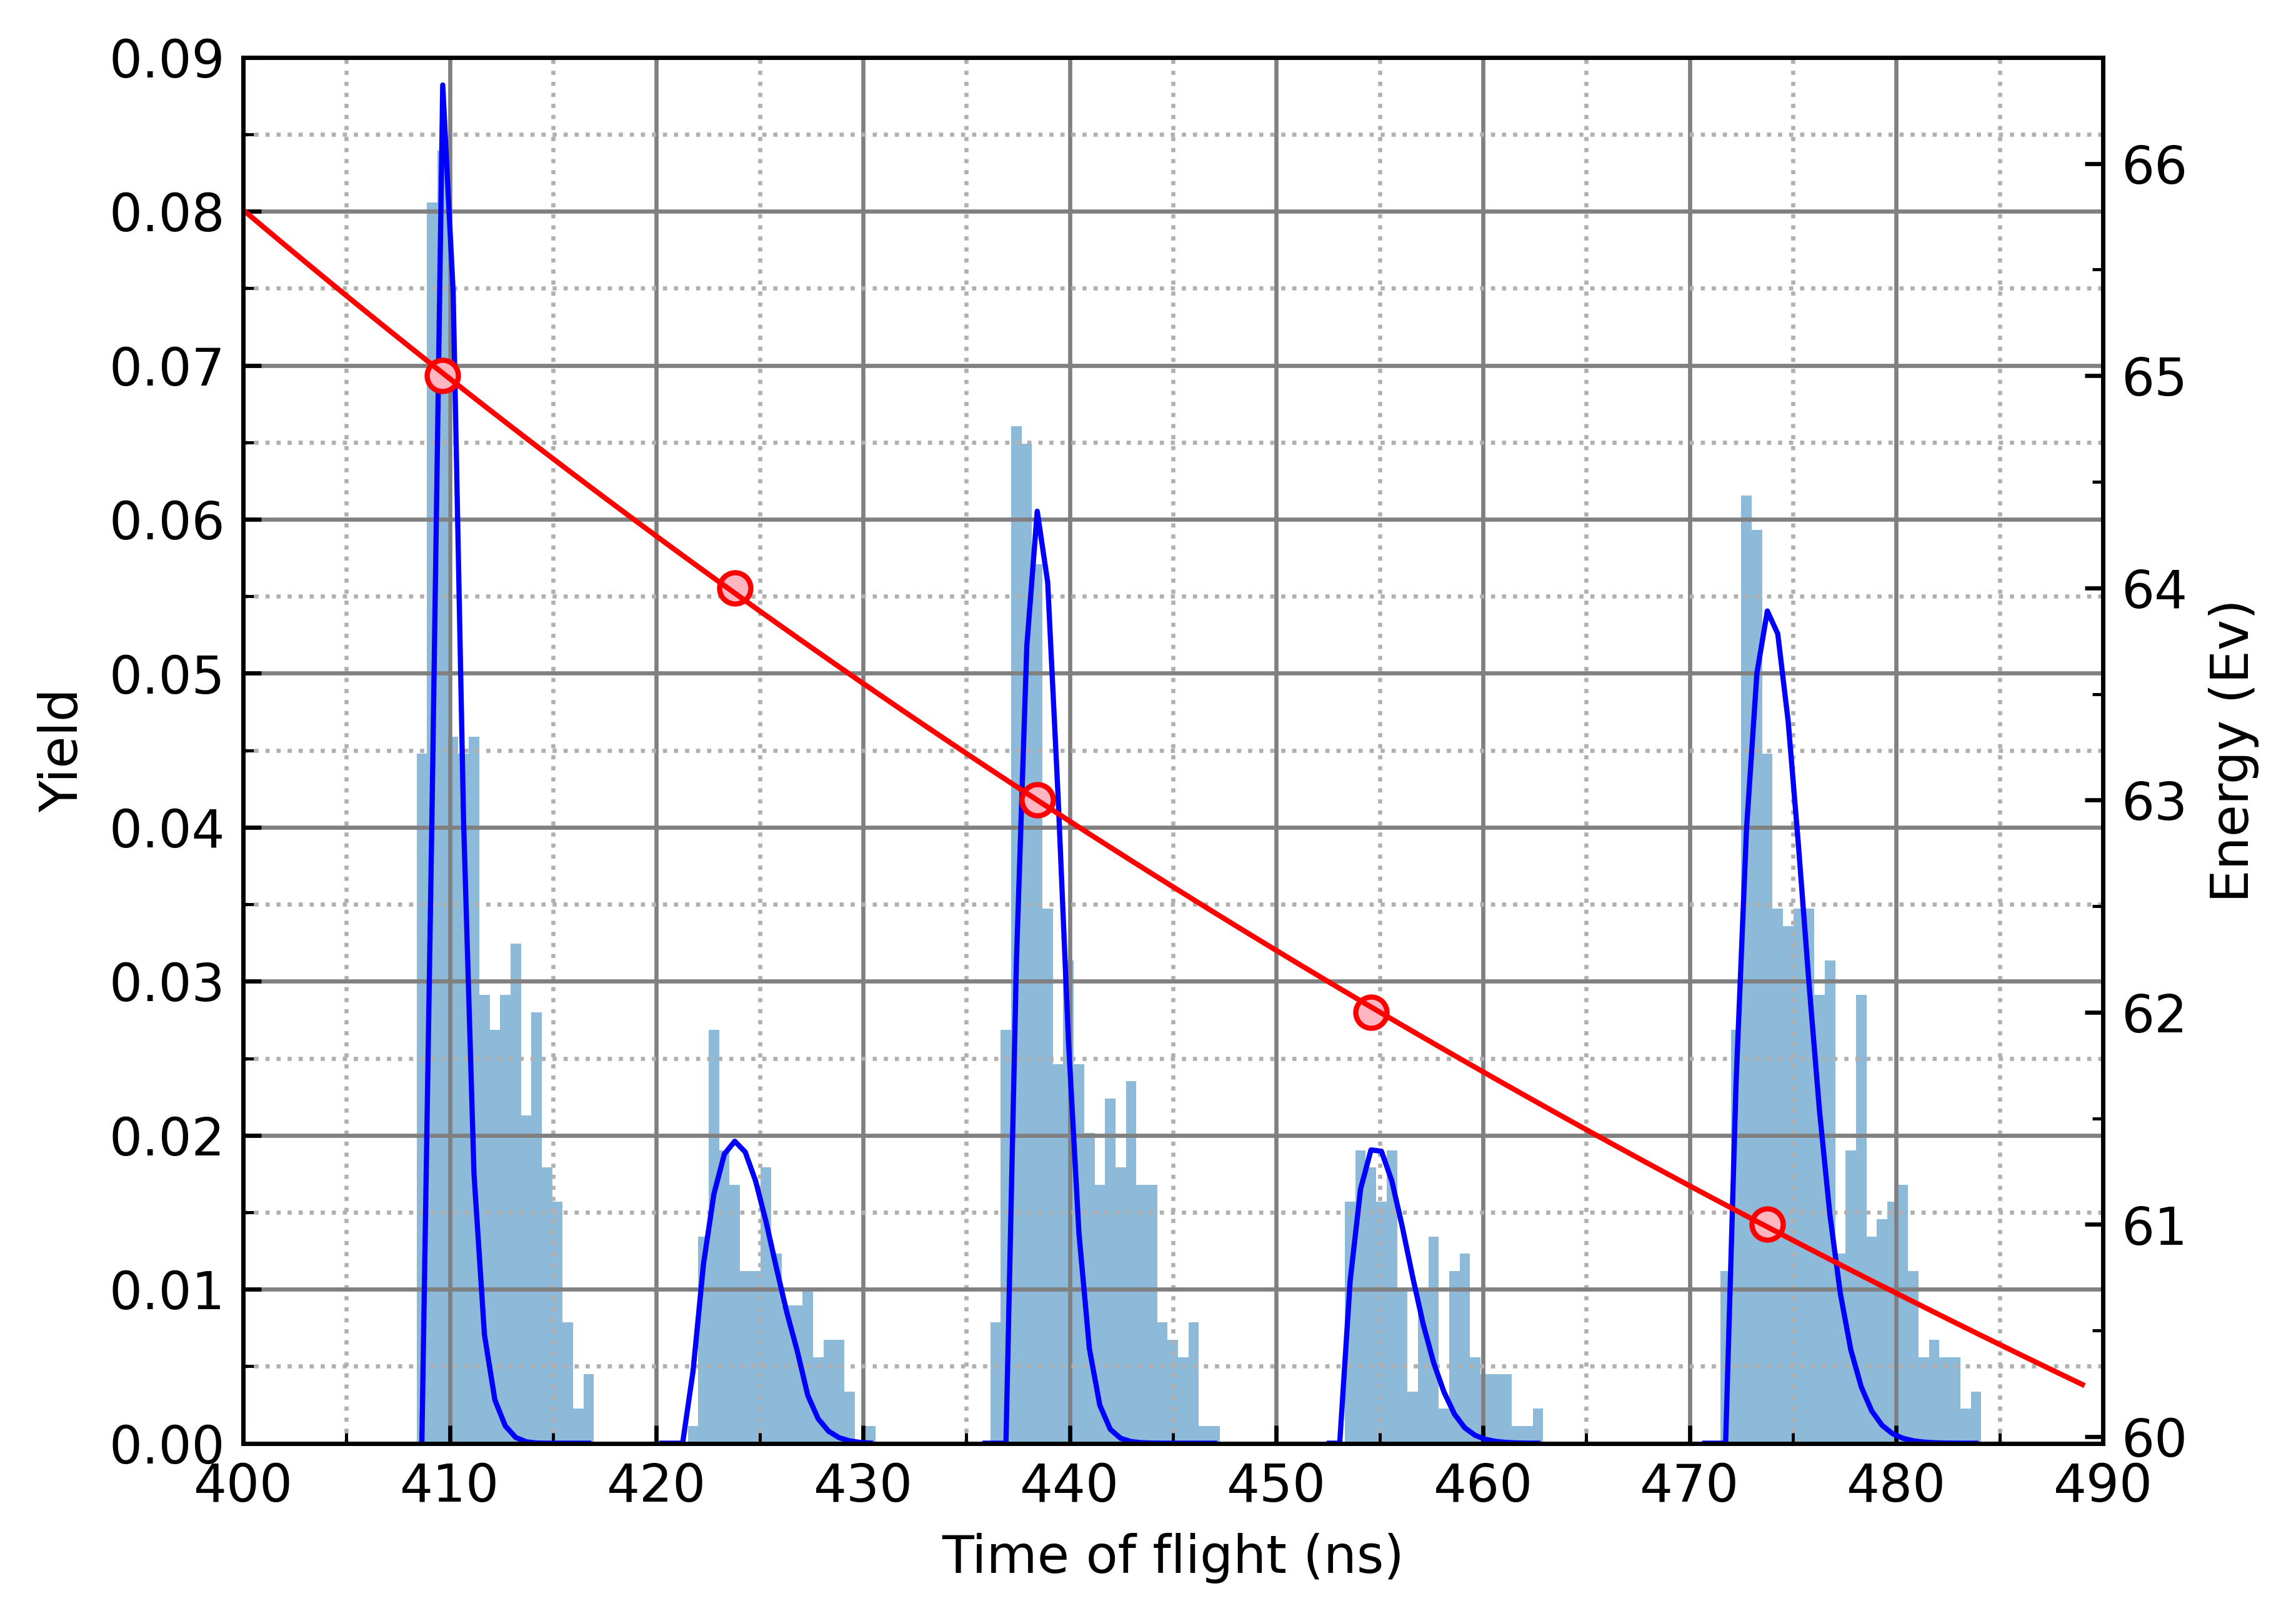

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from funcs import *

fig, ax = plt.subplots(dpi=600)

x_start=400
x_end = 490
x_interval = 10
y_start = 0
y_end = 0.09
y_interval = 0.01
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
          r"Time of flight (ns)", r"Yield", set=True)

data = read_file('./data/5p_ret50_good.txt', delimeter=None)[0]
y, x, _ = plt.hist(data, 150, alpha=0.5, density=True)
x = (x[1:] + x[:-1])/2

times, sigmas, widths = [], [], []
energies = [65, 64, 63, 62, 61]
# straight_times = [409.18, 422.73, 437.28, 454.08, 472.58] # Real
straight_times = [409.39, 423.73, 438.68, 455.08, 473.58]
# bins = [(407.48, 419.48), (419.48, 433.04),
#          (433.04, 449.42), (449.42, 465.80), (465.80, 486.56)]
bins = [(407.48, 417.42), (420.56, 431.16), (436.12, 447.71), (452.67, 463.43), (471.21, 484.62)]

for i, lim in enumerate(bins):
    start, stop = get_bins(lim, x)
    peak_x, sig, width = approximate(x[start:stop], y[start:stop], ax,
                                    (straight_times[i], 1, 0, 1, 1))
    times.append(peak_x)
    sigmas.append(sig)
    widths.append(width)

times, sigmas, widths = np.array(times), np.array(sigmas), np.array(widths)

xr = np.arange(x_start, x_end, 1)
params, _ = curve_fit(time_to_energy, times, energies, (0, 0, 1117))
print(f"Fitted parameters:\nt0 = {params[0]*1e9} ns\nE0 = {params[1]} eV\ns = {params[2]} mm")

ax2 = ax.twinx()
ax2.scatter(times, energies, facecolors='#FFB6C1', edgecolors='r')
ax2.plot(xr, time_to_energy(xr, *params), lw=1, c='red')
decorate(ax2, (x_start, x_end, x_interval), (60, 66, 1),
          r"Time of flight (ns)", r"Energy (Ev)", set=False)
ax2.grid(visible=False, which='both')
#
# print(len(times), len(energies), len(widths))
d = {
    "Energy, eV": energies[:len(times)],
    "t, ns": times,
    "dt, ns": widths,
    "dt/t, %": (widths+1)/times*100,
    # "dE/E, %": widths/times*200,
    # "dE, eV": widths/times*energies,
    # "Sigma, ns": sigmas,
}

def t_ret(E):
    return np.sqrt(ELECTRON_MASS/2)*(90e-3/np.sqrt(E*ELECTRON_CHARGE) +
                                     910e-3/np.sqrt((E-50)*ELECTRON_CHARGE))*1e9

def tof(E: float):
    return 1000 / velocity(E) * 1e9

df = pd.DataFrame(data=d)
for E in range(65, 60, -1):
    t1 = t_ret(E)
    t2 = t_ret(E - 1)
    # t1 = tof(E)
    # t2 = tof(E - 1)
    # print(f"Δt @{el}-{el-2}eV = {t2-t1} ns")
    dt = t2-t1
    # R = dt/tof(E)/2 # двойка потому что по критерию рэлея
    R = dt/t_ret(E)/2
    # print(f"R @{E} = {R*100} %")
    print(E, np.round(R*100, 2), np.round(0.5/2/E*100, 2), t_ret(E), tof(E))
    # print(np.round(R*100, 2))
df

46 


,"Energy, eV","t, ns","dt, ns","dt/t, %"
0,65,209.954457,1.558896,0.742492
1,64,211.252500,1.759681,0.832975
2,63,213.106848,1.895812,0.889607
3,62,214.775761,1.638767,0.763013
4,61,216.630109,2.138413,0.987126


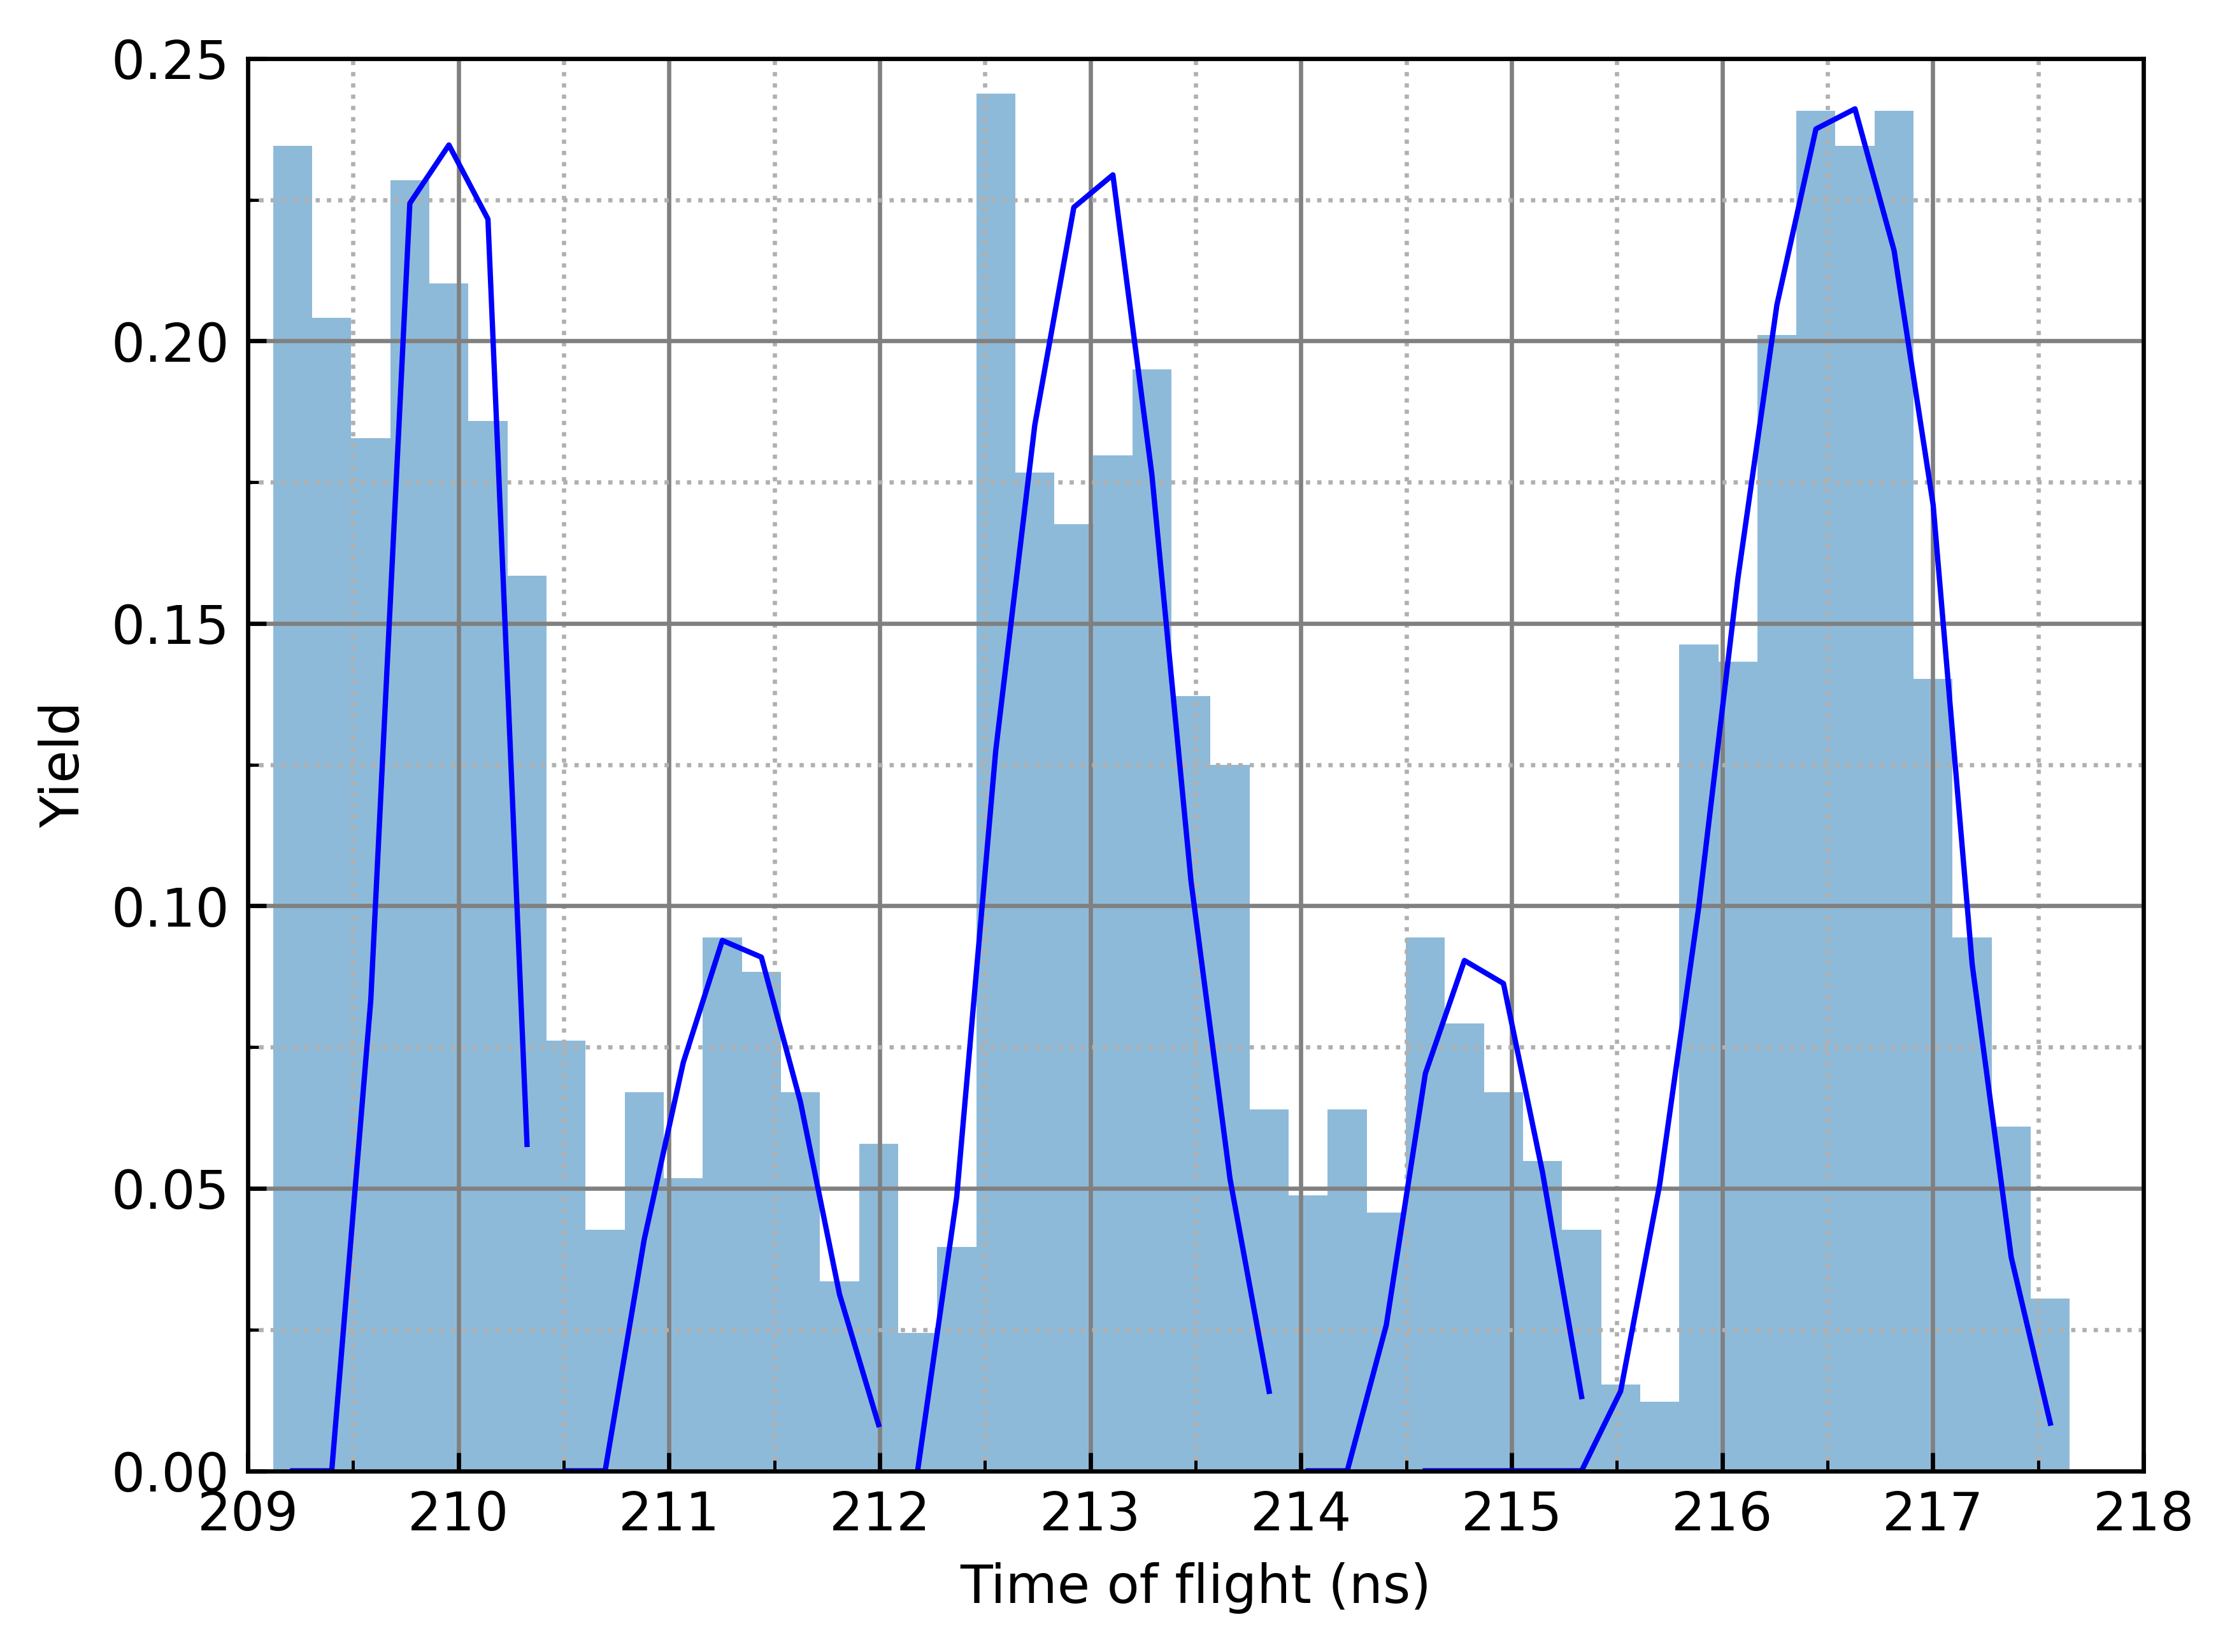

In [36]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from funcs import *

fig, ax = plt.subplots(dpi=600)

x_start = 209
x_end = 218
x_interval = 1
y_start = 0
y_end = 0.25
y_interval = 0.05
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
          r"Time of flight (ns)", r"Yield", set=True)

data = read_file('./data/5p_no_field.txt', delimeter=None)[0]

times, sigmas, widths = [], [], []
energies = [65, 64, 63, 62, 61]
straight_times = [209.92, 211.20, 212.55, 214.652, 216.39]
bins = [(209.049, 210.674), (210.674, 212.299),
        (212.299, 214.041), (214.041, 215.645), (214.595, 217.890)]

interval = bins[3]
M = 1
delta = (interval[0] - interval[1])/M
# 32 
# 33 
# 34 
# 35 
# 37 
# 38 
# 39 
# 40 
# 41 
# 42 
# 43 
# 45 
# 46 
# 49 
# 50 
# 51 
# 52 
# 55 
for N in range(55, 56):
    N = 46
    y, x, _ = plt.hist(data, N, alpha=0.5, density=True)
    x = (x[1:] + x[:-1])/2
    for dx in range(0, M):
        # straight_times[3] = interval[0] + dx*delta
        count = 0

        for i, lim in enumerate(bins):
            start, stop = get_bins(lim, x)
            try:
                peak_x, sig, width = approximate(x[start:stop], y[start:stop], ax,
                                                (straight_times[i], 1, 0, 1, 1))
                times.append(peak_x)
                sigmas.append(sig)
                widths.append(width)
            except:
                continue
            count += 1

        if count == 5:
            print(f"{N} ")
times, sigmas, widths = np.array(times), np.array(sigmas), np.array(widths)
# xr = np.arange(x_start, x_end, 1)
# params, _ = curve_fit(time_to_energy, times, energies, (0, 0, 1117))
# print(f"Fitted parameters:\nt0 = {params[0]*1e9} ns\nE0 = {params[1]} eV\ns = {params[2]} mm")

# ax2 = ax.twinx()
# ax2.scatter(times, energies, facecolors='#FFB6C1', edgecolors='r')
# ax2.plot(xr, time_to_energy(xr, *params), lw=1, c='red')
# decorate(ax2, (x_start, x_end, x_interval), (60, 66, 1),
#           r"Time of flight (ns)", r"Energy (Ev)", set=False)
# ax2.grid(visible=False, which='both')
# #
# # print(len(times), len(energies), len(widths))
d = {
    "Energy, eV": energies[:len(times)],
    "t, ns": times,
    "dt, ns": widths+1,
    "dt/t, %": (widths+1)/times*100,
    # "dE/E, %": widths/times*200,
    # "dE, eV": widths/times*energies,
    # "Sigma, ns": sigmas,
}
df = pd.DataFrame(data=d)
df

## 1000mm 65-61eV 0V <a class="anchor" id="section-2"></a>

## Bundle's deviation <a class="anchor" id="section-5"></a>

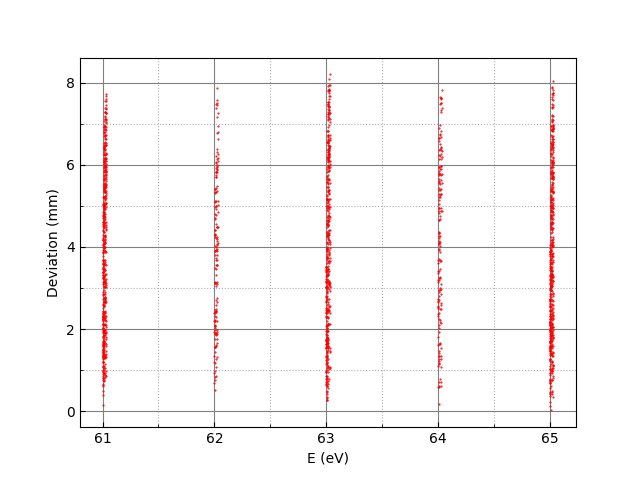

In [34]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from funcs import *

fig, ax = plt.subplots()
x_start = 9
x_end = 80
x_interval = 1
y_start = 0
y_end = 10
y_interval = 2
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
          r"E (eV)", r"Deviation (mm)", set=False)

x = np.arange(x_start, x_end, 1)
energies = [14.40, 13.08, 11.27, 9.95, 8.16, 6.84]
e, r = [], []
with open("./data/dist_coords_noret.txt", "r") as f_c:
    with open("./data/dist_energies_noret.txt", "r") as f_e:
        while True:
            s_c = f_c.readline()
            s_e = f_e.readline()
            if s_c == "" or s_e == "":
                break
            num_c = s_c.split()
            num_e = s_e.split()
            if round(float(num_c[2])) > 0: #== 1016 516
                r.append(np.sqrt(float(num_c[1]) ** 2 + float(num_c[3]) ** 2))
                e.append(float(num_e[1]))

ax.scatter(e, r, s=0.25, c="red", zorder=3)
# ax.vlines(energies, 0, 5, lw=1, color='b')

## 23.76eV single peak <a class="anchor" id="section-8"></a>

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylab import *
from scipy.optimize import curve_fit
from scipy.signal import peak_widths, find_peaks
from funcs import *

fig, ax = plt.subplots(dpi=600)
x_start = 231
x_end = 243
x_interval = 1
y_start = 0
y_end = 0.1
y_interval = 0.05
decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
    r"Time of flight (ns)", r"Yield", set=False)

data, _ = read_file('./data/1k_ret_new.txt', delimeter=None)
y, x, _ = hist(data, 20, alpha=0.5, density=True)
x = (x[1:] + x[:-1]) / 2

times, sigmas, widths = [], [], []
energies = [75-65]
straight_times = time_of_flight(np.array(energies))

def energy_from_time(t, ret_pos, v_ret):
    return 6.242e18*ELECTRON_MASS*0.5*(TUBE_LENGTH*1e6/t)**2

def time_of_flight(E: float, L):  # ns
    return L / velocity(E) * 1e9

bins = [(230, 244)]
for i, lim in enumerate(bins):
    start, stop = get_bins(lim, x)
    peak_x, sig, width = approximate(x[start:stop], y[start:stop], ax, (234, 1, 1, 1, 1))
    times.append(peak_x)
    sigmas.append(sig)
    widths.append(width)

times, sigmas, widths = np.array(times), np.array(sigmas), np.array(widths)

d = {
    "Energy, eV": energies[:len(times)],
    "Theory, ns": straight_times[:len(times)],
    "t, ns": times,
    "dt, ns": widths,
    "dt/t, %": widths/times*100,
    "dE/E, %": widths/times*200,
    "dE, eV": widths/times*energies,
    "Sigma, ns": sigmas,
}
df = pd.DataFrame(data=d)
print(time_of_flight(75, 125)+time_of_flight(10, 1016-125))
print(time_of_flight(75-0.15, 125)+time_of_flight(10-0.15, 516-125))
df

## Adiabaticity parameter graph <a class="anchor" id="section-5"></a>

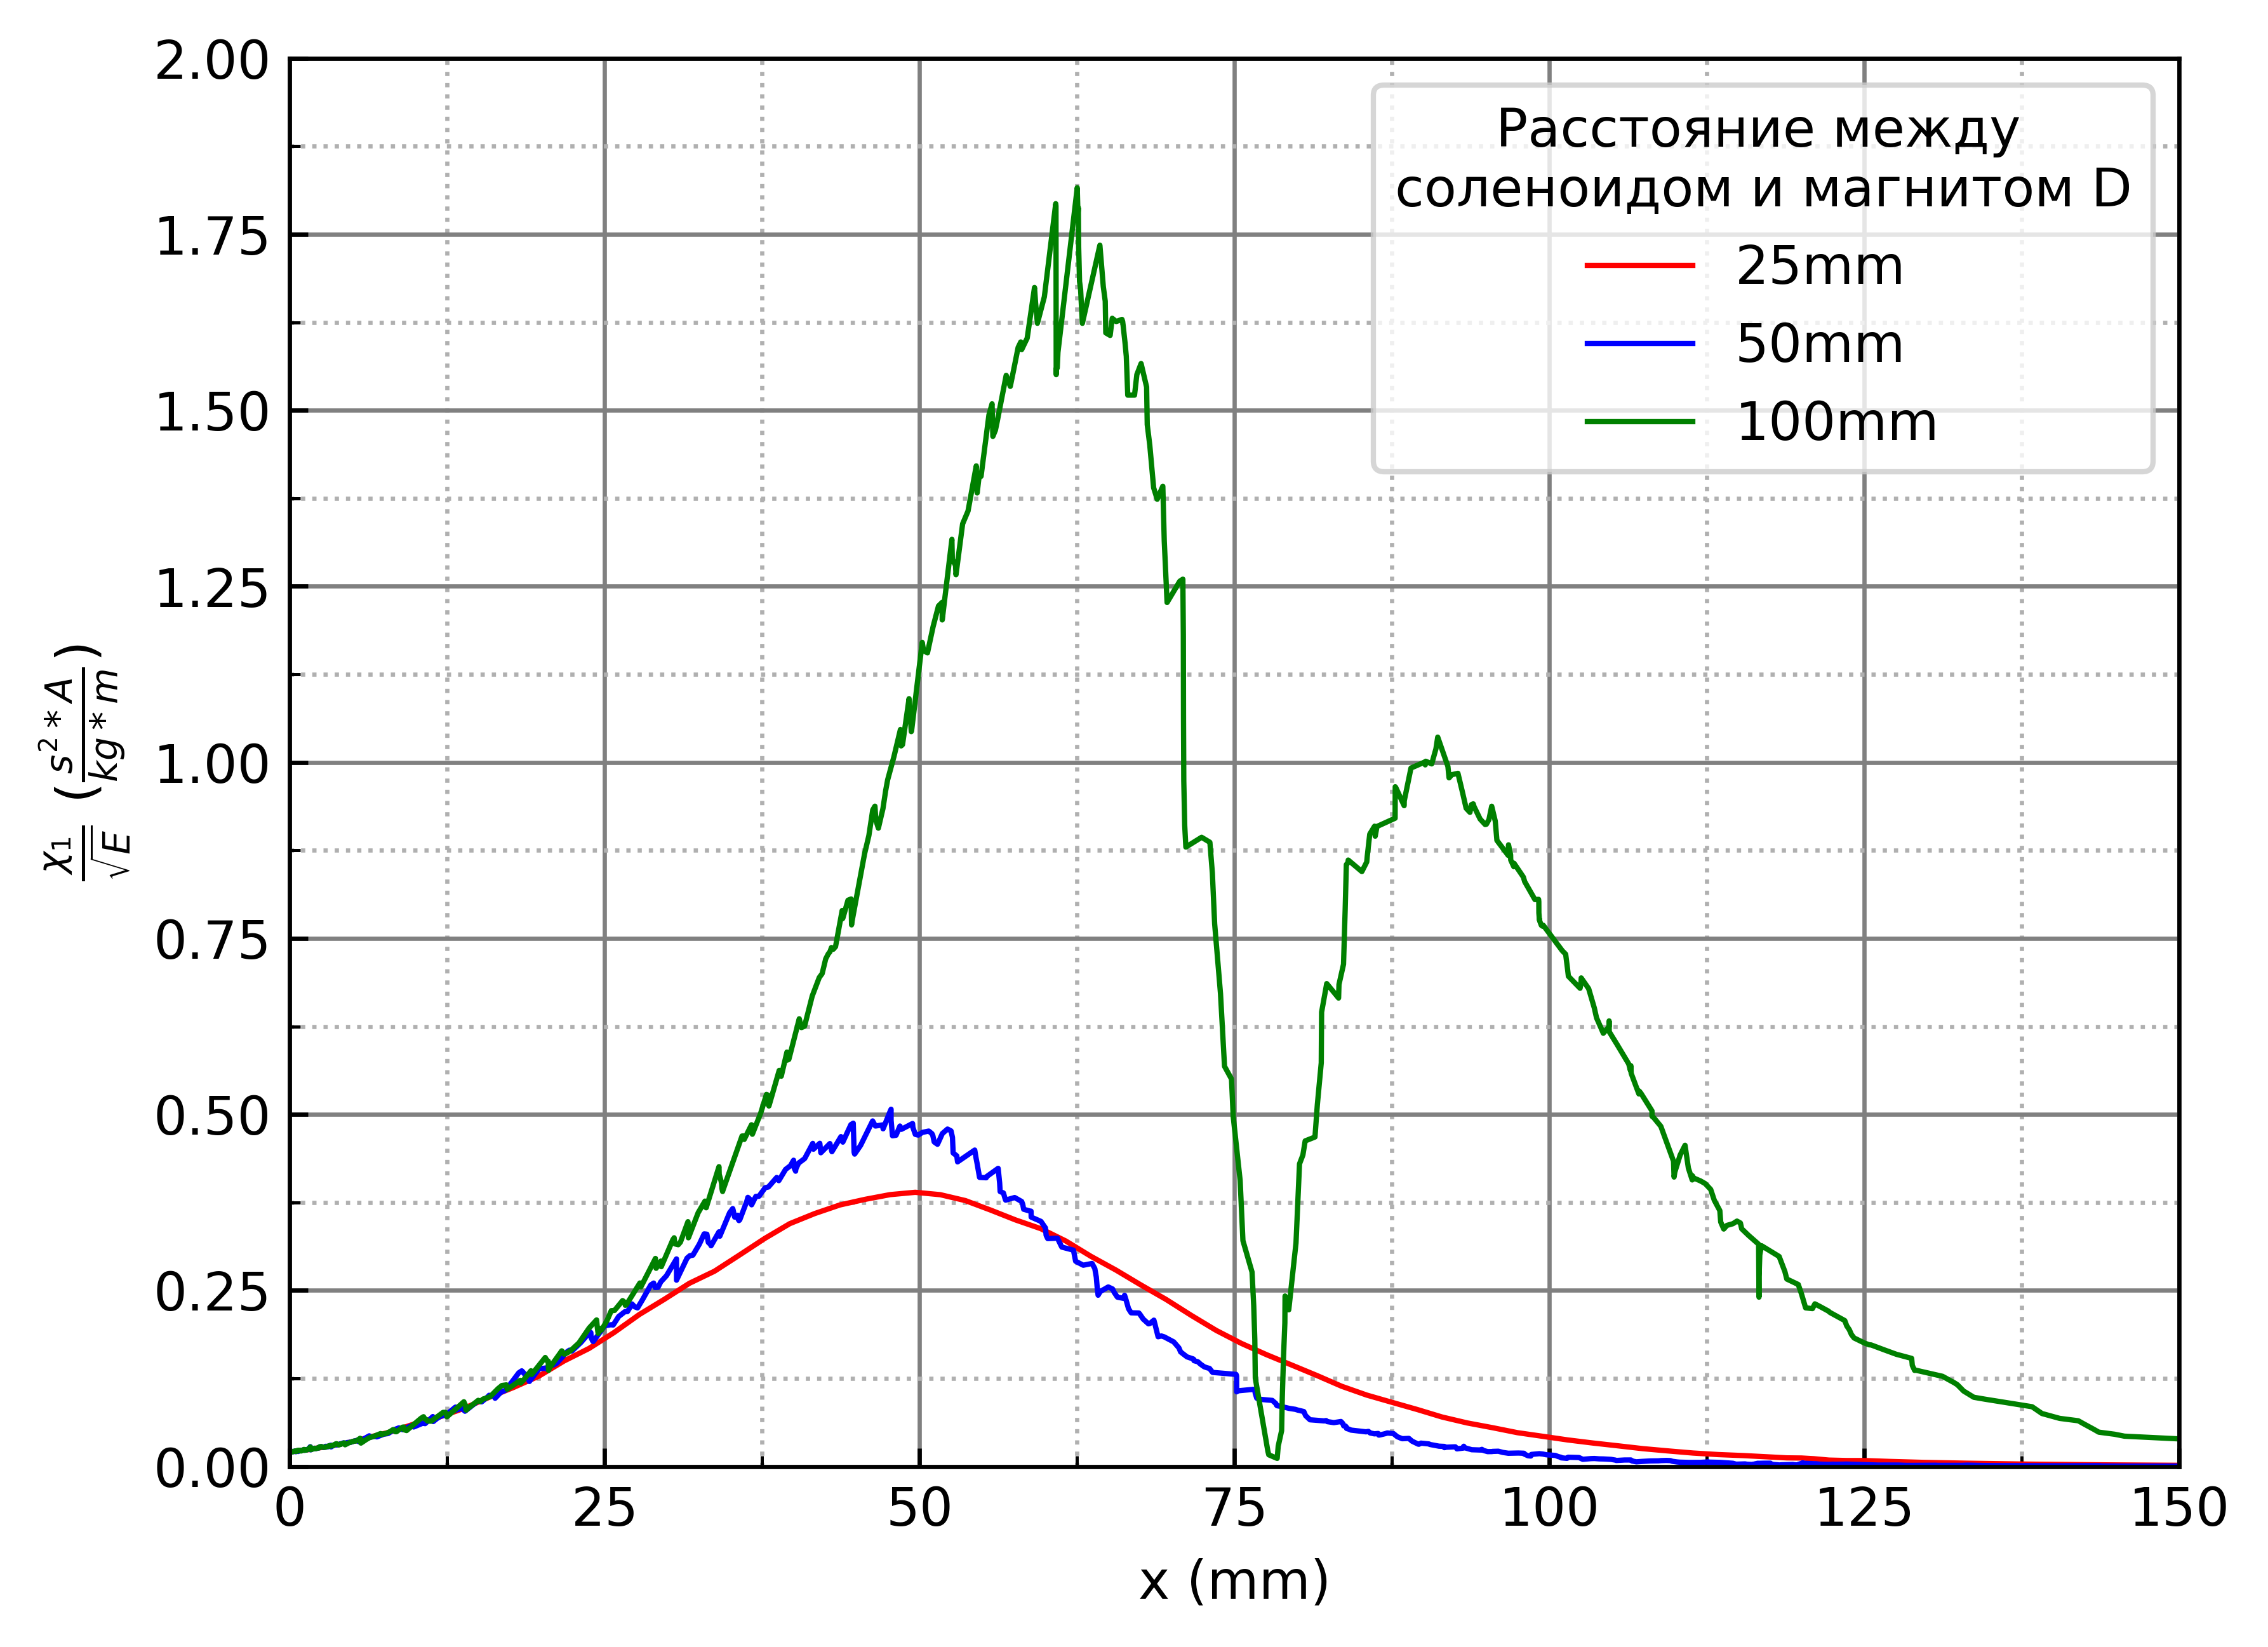

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from funcs import *

fig, ax = plt.subplots(dpi=600)
x_start = 0
x_end = 150
x_interval = 25
y_start = 0
y_end = 2
y_interval = 0.25

x1, y1 = read_file('./data/adiabaticity_25mm.txt', delimeter=None)
x2, y2 = read_file('./data/adiabaticity_50mm.txt', delimeter=None)
x3, y3 = read_file('./data/adiabaticity_100mm.txt', delimeter=None)

ax.plot(x1, y1, c='r', lw=1, label='25mm')
ax.plot(x2, y2, c='b', lw=1, label='50mm')
ax.plot(x3, y3, c='g', lw=1, label='100mm')

decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
    r"x (mm)",
    r"$\frac{\chi_1}{\sqrt{E}}~(\frac{s^2*A}{kg*m})$",
      set=True, legend = True)
leg = ax.legend(title="      Расстояние между\nсоленоидом и магнитом D")

## Flux graph <a class="anchor" id="section-5"></a>

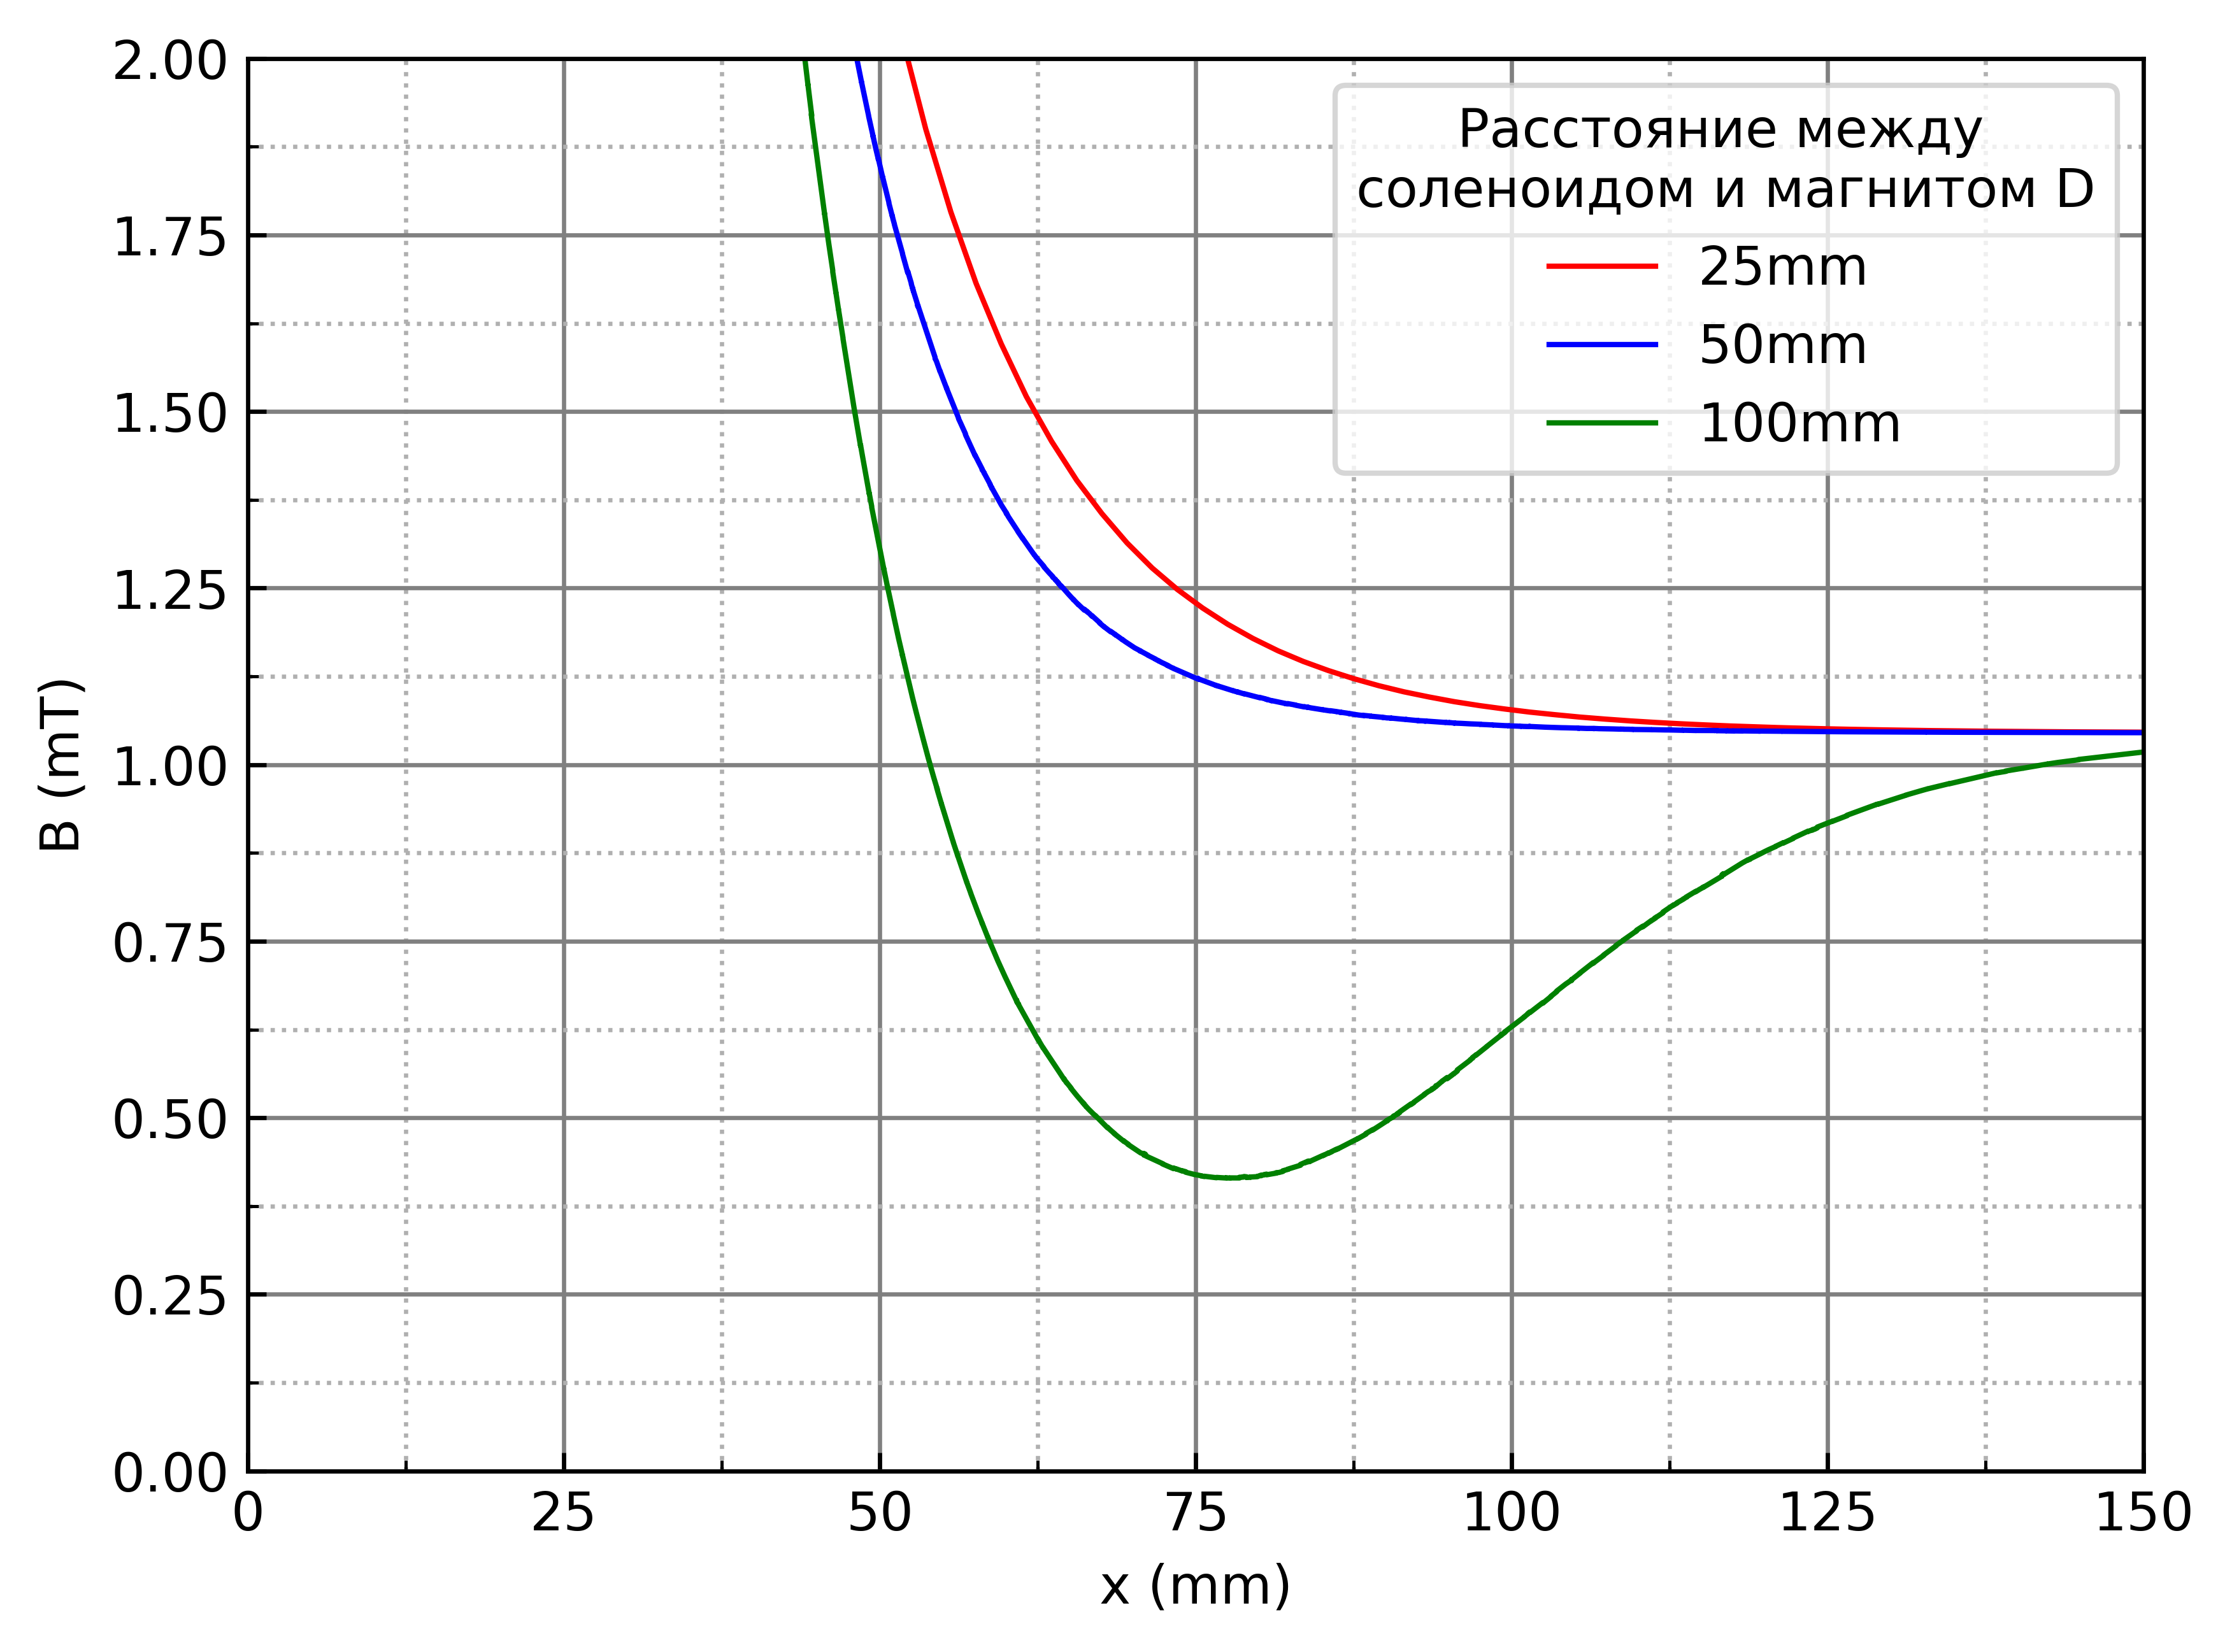

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from funcs import *

fig, ax = plt.subplots(dpi=600)
x_start = 0
x_end = 150
x_interval = 25
y_start = 0
y_end = 2
y_interval = 0.25

x1, y1 = read_file('./data/flux_25mm.txt', delimeter=None)
x2, y2 = read_file('./data/flux_50mm.txt', delimeter=None)
x3, y3 = read_file('./data/flux_100mm.txt', delimeter=None)

ax.plot(x1, y1, c='r', lw=1, label='25mm')
ax.plot(x2, y2, c='b', lw=1, label='50mm')
ax.plot(x3, y3, c='g', lw=1, label='100mm')

decorate(ax, (x_start, x_end, x_interval), (y_start, y_end, y_interval),
    r"x (mm)",
    r"B (mT)",
      set=True, legend = True)
ax.legend(title="      Расстояние между\nсоленоидом и магнитом D")